In [1]:
!nvidia-smi

Tue May 30 15:47:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [13]:
import torch #torch 자체
import torch.nn as nn  #torch에서 network 성분 가져올때
import torch.nn.functional as F #activation function등을 저장하고 있음 

from torchsummary import summary
import torch.optim as optim #나중에 다루자
from torch.utils.data import DataLoader,random_split 
from torchvision import datasets, transforms  # dataset은 데이터셋 저장, transforms는 data augmentation기법에 사용
from torchvision import utils

import numpy as np
import matplotlib.pyplot as plt

In [4]:
import torch.backends.cudnn as cudnn
import random
#파이토치의 랜덤시드 고정
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0) # gpu 1개 이상일 때 

# 넘파이 랜덤시드 고정
np.random.seed(0)

#CuDNN 랜덤시드 고정
cudnn.benchmark = False
cudnn.deterministic = True 

# 파이썬 랜덤시드 고정
random.seed(0)

 ### Step 1) 데이터 불러오기 및 전처리 

In [5]:
transform = transforms.Compose( #전처리에 사용됩니다 
    [transforms.ToTensor(), #tensor 라는 것으로 바꿔주는데 pytorch 내부에서는 tensor만 가지고 연산합니다. 반드시 반드시 넣어줘야해요
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))] #normalize는 mean, std를 받아서 그것에 맞춰서 normalize해줍니다. 
     )

In [6]:
train_dataset = datasets.CIFAR10(root="../data", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root="../data", train=False, download=True, transform=transform)
split = 0.2
val=int(len(train_dataset)*split)
train = int(len(train_dataset)*(1-split))
train, valid = random_split(train_dataset,[train,val])
print(len(train),len(valid))

100%|██████████| 170498071/170498071 [00:05<00:00, 29648348.33it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified
40000 10000


In [7]:
BATCH_SIZE = 64
EPOCH = 10
learning_rate = 0.001

In [8]:

train_loader = DataLoader(train,batch_size=BATCH_SIZE,num_workers=2)
valid_loader = DataLoader(valid,batch_size=BATCH_SIZE,num_workers=2) 
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

image, label = next(iter(train_loader))

## 네트워크 생성
### fc와 CNN을 비교해볼게요

In [18]:
#nn의 module을 상속받아서 그 위에 layer를 쌓아올림
#linear안에는 input, output sizef를 입력할 수 있습니다.
class FC_Model(nn.Module):  #네트워크 구성 성분 입력
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3072,2048)
        self.fc2 = nn.Linear(2048,1024)
        self.fc3 = nn.Linear(1024,512)
        self.fc4 = nn.Linear(512,256)
        self.fc5 = nn.Linear(256,10)

    def forward(self,x):
      x = self.flatten(x) #3*32*3 => 3072
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = F.relu(self.fc3(x))
      x = F.relu(self.fc4(x))
      x = self.fc5(x)
      return x


CNN을 직접 구성할 일이 많지는 않겠지만 구성해야한다면 현재 레이어의 out_channel과 다음 채널의in_channel을 맞춰줘야한다는 점을 기억해주세요

In [17]:
class CNN_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5,padding='same')
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5,padding='same')
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding='same')
        self.conv4 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding='same')
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.conv5 = nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,padding='same')# 8*8*128
        self.pool3 = nn.MaxPool2d(kernel_size=2) #4*4*128
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(2048,256)
        self.fc3 = nn.Linear(256,10)

    def forward(self,x):
      x = F.relu(self.conv1(x))
      x = F.relu(self.conv2(x))
      x = self.pool1(x)
      x = F.relu(self.conv3(x))
      x = F.relu(self.conv4(x))
      x = self.pool2(x)
      x = F.relu(self.conv5(x))
      #x = F.relu(self.conv6(x))
      x = self.pool3(x)
      x = self.flatten(x)
      x = F.relu(self.fc1(x))
      x = self.fc3(x)
      return x
 

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [19]:
fc_model = FC_Model()
fc_model.to(device) #device로 보내줘야지 gpu를 사용합니다


FC_Model(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3072, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=10, bias=True)
)

In [20]:
summary(fc_model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                 [-1, 2048]       6,293,504
            Linear-3                 [-1, 1024]       2,098,176
            Linear-4                  [-1, 512]         524,800
            Linear-5                  [-1, 256]         131,328
            Linear-6                   [-1, 10]           2,570
Total params: 9,050,378
Trainable params: 9,050,378
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 34.52
Estimated Total Size (MB): 34.59
----------------------------------------------------------------


In [21]:
cnn_model = CNN_Model()
cnn_model.to(device) #device로 보내줘야지 gpu를 사용합니다

CNN_Model(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [22]:
summary(cnn_model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]           1,216
            Conv2d-2           [-1, 32, 32, 32]          12,832
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
            Conv2d-5          [-1, 128, 16, 16]          73,856
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]         147,584
         MaxPool2d-8            [-1, 128, 4, 4]               0
           Flatten-9                 [-1, 2048]               0
           Linear-10                  [-1, 256]         524,544
           Linear-11                   [-1, 10]           2,570
Total params: 781,098
Trainable params: 781,098
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

### Step 3) 손실 함수 (Loss) 및 업데이트 알고리즘 (Optimizer) 설정


In [23]:
criterion = nn.CrossEntropyLoss()
fc_optimizer = optim.Adam(params=fc_model.parameters(), lr=learning_rate)
cnn_optimizer = optim.Adam(params=cnn_model.parameters(), lr=learning_rate)

In [24]:
def trainer(model,EPOCH,criterion,optimizer): 
  train_loss_per_epoch = []
  val_loss_per_epoch = []
  val_acc_per_epoch = []
  for epoch in range(EPOCH):  
      train_loss = 0

      for i, data in enumerate(train_loader):
          # Batch에 해당하는 Data 추출
          x, y_true = data #x는 input data에 해당 y_true는 label에
          x = x.to(device) 
          y_true = y_true.to(device) 

          optimizer.zero_grad() #gradient 초기화
          # 입력에 대한 결과 예측
          y_pred = model(x)

          # 예측값과 정답을 비교하여 손실함수의 값 계산
          loss = criterion(y_pred, y_true) 
          # 손실함수의 값이 작아지는 방향으로 네트워크 업데이트
          loss.backward() #back propagation
          optimizer.step() #update
          train_loss += loss.item() 
      train_loss /= len(train_loader)
      train_loss_per_epoch.append(train_loss) #로깅용 running_loss epoch 당 loss 가지고 있음
     
      correct = 0
      total = 0
      val_loss = 0
      with torch.no_grad(): #gradient tracking을 꺼버림
          for i, data in enumerate(valid_loader):
          #for i, (images,labels) in enumerate(valid_loader):
              images,labels=data
              images = images.to(device)
              labels = labels.to(device)
              outputs = model(images)
              loss = criterion(outputs,labels)
              val_loss += loss.item()
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()
              val_acc = 100 * correct / total

      val_loss = val_loss / len(valid_loader)
      val_loss_per_epoch.append(val_loss)
      val_acc_per_epoch.append(val_acc)
      print('Epoch {}, Train Loss: {}, Val Loss: {}, Val Acc: {}'.format(epoch, train_loss, val_loss, val_acc ))
  return train_loss_per_epoch,val_loss_per_epoch, val_acc_per_epoch


In [25]:
fc_train_loss,fc_val_loss,fc_acc=trainer(fc_model,EPOCH,criterion,fc_optimizer) 

Epoch 0, Train Loss: 1.7378188682556153, Val Loss: 1.6146512775664117, Val Acc: 43.24
Epoch 1, Train Loss: 1.5142559055328368, Val Loss: 1.5370530391195019, Val Acc: 46.86
Epoch 2, Train Loss: 1.3813760405540467, Val Loss: 1.511747843900304, Val Acc: 48.35
Epoch 3, Train Loss: 1.2692728721618651, Val Loss: 1.5509260095608461, Val Acc: 48.87
Epoch 4, Train Loss: 1.1664115595817566, Val Loss: 1.5887089815868694, Val Acc: 49.19
Epoch 5, Train Loss: 1.0763320740699769, Val Loss: 1.6975635183844597, Val Acc: 48.98
Epoch 6, Train Loss: 0.9951661655426025, Val Loss: 1.7839197011510277, Val Acc: 49.06
Epoch 7, Train Loss: 0.924976078414917, Val Loss: 1.8195081911269266, Val Acc: 49.31
Epoch 8, Train Loss: 0.8481369026184082, Val Loss: 1.8608394754920037, Val Acc: 50.69
Epoch 9, Train Loss: 0.7900261262893676, Val Loss: 1.9466004789255227, Val Acc: 50.11


In [26]:
cnn_train_loss,cnn_val_loss,cnn_acc=trainer(cnn_model,EPOCH,criterion,cnn_optimizer) 

Epoch 0, Train Loss: 1.5974242734909057, Val Loss: 1.2961501414608803, Val Acc: 53.05
Epoch 1, Train Loss: 1.1188373949050903, Val Loss: 0.9984147765074566, Val Acc: 64.16
Epoch 2, Train Loss: 0.8727431383132934, Val Loss: 0.9193018955789554, Val Acc: 68.44
Epoch 3, Train Loss: 0.7142203017234803, Val Loss: 0.8745310401460927, Val Acc: 70.82
Epoch 4, Train Loss: 0.6006489156484603, Val Loss: 0.9104962037627105, Val Acc: 70.58
Epoch 5, Train Loss: 0.5138635891675949, Val Loss: 0.8974382528074228, Val Acc: 71.46
Epoch 6, Train Loss: 0.4446763278007507, Val Loss: 0.9312199608535524, Val Acc: 71.86
Epoch 7, Train Loss: 0.37864368382692337, Val Loss: 1.0964257743707888, Val Acc: 70.84
Epoch 8, Train Loss: 0.3342874550104141, Val Loss: 1.141081060193906, Val Acc: 70.58
Epoch 9, Train Loss: 0.27634807834625247, Val Loss: 1.2470720007920721, Val Acc: 70.17


### Step 5) 성능평가 (Evaluation)

In [27]:
def evaluation(model):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
            
  return test_acc

In [28]:
print(evaluation(fc_model))

50.87


In [29]:
print(evaluation(cnn_model))

70.5


In [30]:
def loss_visualization(EPOCH,train_loss_per_epoch,val_loss_per_epoch):
  plt.title("val/train loss for epoch")
  plt.plot(np.arange(EPOCH),train_loss_per_epoch,label='train_loss')
  plt.plot(np.arange(EPOCH),val_loss_per_epoch,label='val_loss')
  plt.ylim([0, 2.5])
  plt.legend()
  plt.show()

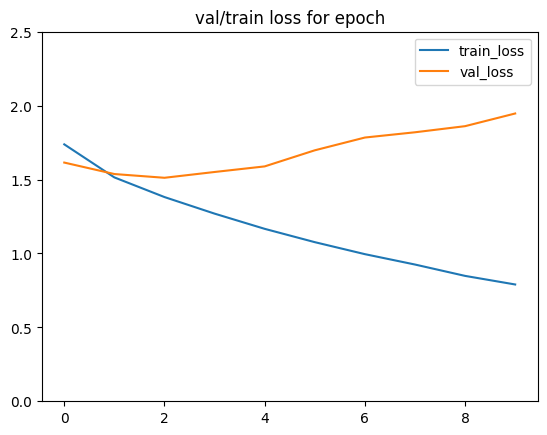

In [31]:
loss_visualization(EPOCH,fc_train_loss,fc_val_loss)

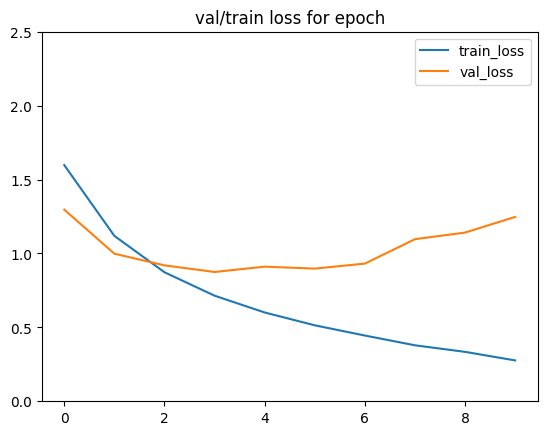

In [32]:
loss_visualization(EPOCH,cnn_train_loss,cnn_val_loss)